In order to make sure that all cells of code run properly throughout this lesson, please run the following cell of code below:

In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute 
from qiskit.visualization import plot_histogram

import math as m 

S_simulator = Aer.backends(name='statevector_simulator')[0]

M_simulator = Aer.backends(name='qasm_simulator')[0]

In [2]:
def Binary(N,total,LSB):
  '''
  Input: N (integer) total (integer) LSB (string)
  Returns the base-2 binary equivilant of N according to left or right least significant bit notation
  '''
  qubits = int(m.log(total, 2))
  b_num = np.zeros(qubits)
  for i in np.arange(qubits):
    if( N/((2)**(qubits-i-1)) >= 1):
      if (LSB == 'R'):
        b_num[i] = 1
      if(LSB== 'L'):
        b_num[int(qubits-(i+1))] = 1
      N = N - 2**(qubits-i-1)
  B = []
  for j in np.arange(len(b_num)): 
    B.append(int(b_num[j]))
  return B

In [3]:
'''
Do not worry about the length of this code block.
You dont need to understand this code.
It is only to help you view the wavefunction in a better way
'''
import numpy as np
import scipy as sci

def Wavefunction( obj, *args, **kwargs):
  '''
  Displays the wavefunction of the quantum system
  '''
  if(type(obj) == QuantumCircuit ):
    statevec = execute( obj, S_simulator, shots=1 ).result().get_statevector() 
  if(type(obj) == np.ndarray):
    statevec = obj
  sys = False
  NL = False
  dec = 5
  if 'precision' in kwargs:
    dec = int(kwargs['precision'] )  
  if 'column' in kwargs:  
    NL = kwargs['column']
  if 'systems' in kwargs:
    systems=kwargs['systems']
    sys = True
    last_sys= int(len(systems)-1)
    show_systems = []
    for s_chk in np.arange(len(systems)): 
      if( type(systems [s_chk])!=int ):
        raise Exception('systems must be an array of all integers')
    if 'show_systems' in kwargs: 
      show_systems = kwargs['show_systems']
      if(len(systems)!=len (show_systems) ):
        raise Exception('systems and show_systems need to be arrays of equal length')
      for ls in np.arange(len(show_systems)): 
        if((show_systems [ ls]!=True) and (show_systems [ ls] !=False)): 
          raise Exception('show_systems must be an array of Truth Values') 
        if(show_systems [ ls] ==True): 
          last_sys= int(ls)

    else:
      for ss in np.arange(len(systems)): 
        show_systems.append(True)
  wavefunction = ''
  qubits = int(m.log(len(statevec),2))
  for i in np.arange( int(len(statevec)) ): 
    value = round(statevec[int(i)].real, dec) + round(statevec[int(i)].imag, dec) * 1j
    if( (value.real!=0) or (value.imag!=0)): 
      state= list(Binary(int(i), int(2**qubits),'L'))
      state_str = ''
      if( sys == True ):    #Systems and Show Systems
        k = 0 
        for s in np.arange(len(systems)):
          if(show_systems [s]==True):
            if(int(s)!=last_sys):
              state.insert(int(k+systems [s]), '>|' ) 
              k = int(k+systems[s]+1)
            else:
              k = int(k+systems[s])
          else:
            for s2 in np.arange(systems [s]): 
              del state[int(k)]
      for j in np.arange(len(state)):
        if(type(state[j])!=str):
          state_str = state_str+str(int(state[j]))
        else:
          state_str = state_str+state[j]
      if ((value.real!=0) and (value.imag!=0)):
        if( value.imag> 0):
          wavefunction = wavefunction + str(value.real) + '+' + str(value.imag) + 'j |' + state_str + '>   '
        else:
          wavefunction = wavefunction + str(value.real) +'' + str(value.imag) + 'j |' + state_str + '>    '
      if( (value.real!=0) and (value.imag==0)): 
        wavefunction = wavefunction +str(value.real)+' |'+state_str +'>     '
      if((value.real==0) and (value.imag!=0)): 
        wavefunction = wavefunction +str(value.imag)+'j |'+state_str+ '>     '
      if (NL):
        wavefunction = wavefunction + '\n'
  print(wavefunction)


# **Higher Order Control Gates**
***

The functions that we are about to study will be used very frequently in the coming lab lessons, but not necessarily always
on display. In particular, many of the algorithms we will study in future labs will require higher order control gates as a smaller
component. As we saw in one of the initial lab sessions,
Qiskit’s standard gates only comes with a handful of control gates. In particular, the largest of which use two control qubits
(CCNOT). While the gates provided by Qiskit are all that we need for a universal set, it will be helpful to define our own
function for constructing these higher order control gates.

## **The Stratergy**
***
The way we are going to construct our higher order control gates is a straightforward strategy, using only CCNOT and CNOT
gates. **This approach is by no means optimal for many cases, but it is a good foundation for how a higher order control gate
should function**.

The major hurdle to overcome is that we must use the conditions on N qubits in order to invoke a single operation. A single
CCNOT gate can only take two control qubits at a time, thus leaving us well short of our goal. However, the trick to this strategy will be to use the aid of ancilla qubits. In essence, these ancilla qubits will allow us to temporarily store information about our
control qubits, and ultimately determine whether or not to apply the operation.



In [20]:
def CCCC_NOT(q):

    anc = []
    for i in np.arange(2):
        s = 2*i
        if( (q[s]==1) and (q[s+1]==1) ):
            anc.append(1)
        else:
            anc.append(0)
    return anc

state1 = [1,1,1,1] 
state2 = [1,1,1,0]

anc1 = CCCC_NOT (state1)
anc2 = CCCC_NOT(state2)

print('state 1: ',state1,' ancilla 1:',anc1)
print('state 2: ',state2,' ancilla 2:', anc2)  

state 1:  [1, 1, 1, 1]  ancilla 1: [1, 1]
state 2:  [1, 1, 1, 0]  ancilla 2: [1, 0]


In this example, we can see that ’state1’ results in the state of all 1’s for the ancilla system, while ’state2’ results in a 0 for
the second ancilla qubit. If we were to use these two ancilla qubits as the control qubits for a CCNOT, the first system would
receive the operation, while the second wouldn’t. If we compare this result to our initial states, we would have achieved exactly
a 4-qubit control gate: the state |1111⟩ receives the operation while the state |1110⟩ does not.

The key point to this example is the way in which we reduced our 4-qubit problem down to 2. Specifically, we work through
our control qubits in groups of 2, putting an ancilla qubit in the state |1⟩ or |0⟩ depending on if the two control qubits are in the
state |11⟩ or not. For our quantum code, we are going to invoke this strategy using CCNOT gates to reduce the dimension of our
problem by 1 per CCNOT gate, until we eventually arrive at only 2 ancilla qubits:

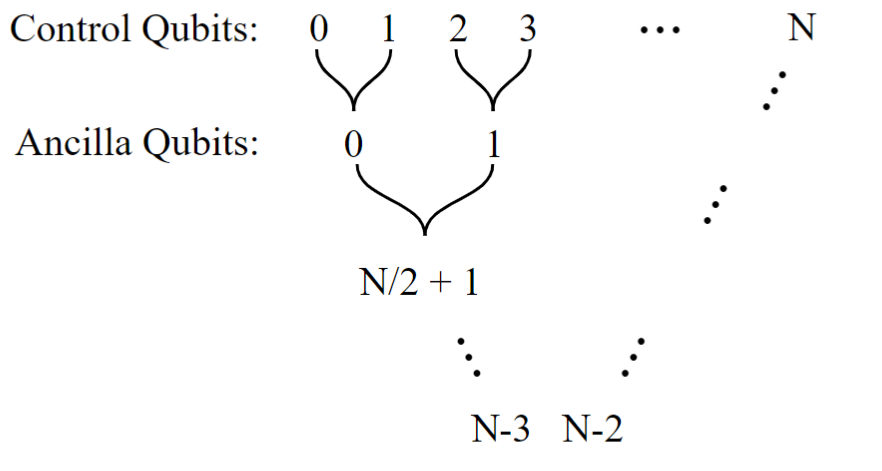

In this diagram, each layer moving downward holds the information about the preceding layer, where the control qubits are
the highest layer (and ultimately the source of the operation). The junctions connecting two qubits in the diagram represent
a CCNOT gate, where the resulting state of the ancilla qubit is |1⟩ if both control qubits are in the |1⟩ state, and a |0⟩
if either of the controlling qubits are in the state |0⟩. Using this recursive process, if a single qubit from the highest layer
is in the |0⟩ state, it will trickle down all the way to the final layer, which in turn will mean the control-operation does not happen.

Now, in order for this strategy to work, we need all of the ancilla qubits to be initialized in the state |0⟩. This is because each
operation is a CCNOT gate, which is effectively a 2-qubit control X gate. Thus, in order for this CCNOT gate to leave the target ancilla qubits in the state |1⟩, only when control qubits are in the |1⟩ state, the target qubit must initially be in the |0⟩ state.

In total, in order to condense the information of N control qubits down to two ancilla qubits, we require N − 2 ancilla qubits.
From there, if we wish to combine these two final ancilla qubits down to one, for a single qubit control gate, we will require 1
additional ancilla qubit, bringing our total to N − 1.

Now, requiring up to N − 1 ancilla qubits just to perform an operation on N qubits may seem like a steep price to pay.
Truthfully, it is. Qubits are not exactly plentiful on current quantum computers, which makes this general strategy a little too
resource intensive to be practical in most cases. However, this is a problem to keep in mind, but ignore for the time being. Our
goal in these lessons is to learn the basics of quantum algorithms, not solve current research efforts (that’s your job afterwards).
In the coming lessons we will be using this higher order control strategy frequently, because we have the luxury of using
simulated qubits.

Now then, let’s take a look at what the diagram above looks like in terms of a quantum circuit diagram, using N = 4 as our
example

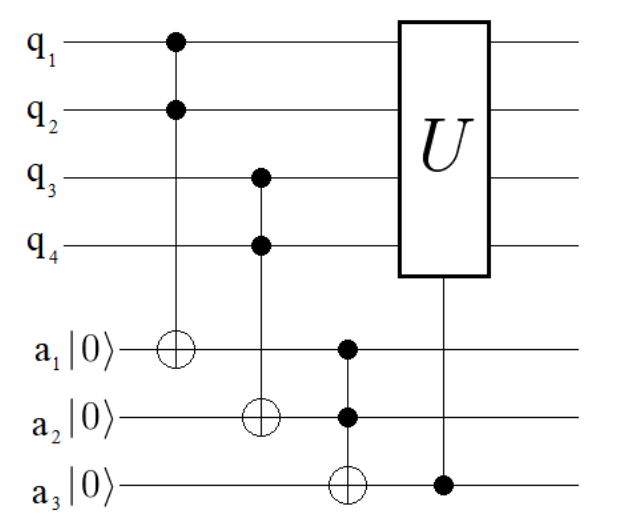

In this diagram, we are performing the general N -control gate strategy. By using three ancilla qubits, we are able to condense
the information of all the states stored on our 4-qubit system, down to a single control ancilla. The operator U in the diagram
represents any single control gate we’ve already seen thus far in 2nd lab lession. As an example, let’s implement this diagram in code,
replacing U with a control-Z gate:

In [21]:
q =  QuantumRegister(7, name='q')

qc = QuantumCircuit(q, name='qc')

qc.h( q[0] )
qc.h( q[1] )
qc.h( q[2])
qc.h( q[3] )
qc.id( q[4])
qc.id( q[5])
qc.id( q[6])

print(' _ Inital State _ ') 
Wavefunction(qc, systems=[4,3], column=True)

qc.ccx( q[0], q[1], q[4] )
qc.ccx( q[2], q[3], q[5])
qc.ccx( q[4], q[5], q[6] ) 
qc.cz( q[6], q[0] )

print('\n After CCCZ _') 
Wavefunction(qc, systems=[4,3], column=True)

 _ Inital State _ 
0.25 |0000>|000>     
0.25 |1000>|000>     
0.25 |0100>|000>     
0.25 |1100>|000>     
0.25 |0010>|000>     
0.25 |1010>|000>     
0.25 |0110>|000>     
0.25 |1110>|000>     
0.25 |0001>|000>     
0.25 |1001>|000>     
0.25 |0101>|000>     
0.25 |1101>|000>     
0.25 |0011>|000>     
0.25 |1011>|000>     
0.25 |0111>|000>     
0.25 |1111>|000>     


 After CCCZ _
0.25 |0000>|000>     
0.25 |1000>|000>     
0.25 |0100>|000>     
0.25 |0010>|000>     
0.25 |1010>|000>     
0.25 |0110>|000>     
0.25 |0001>|000>     
0.25 |1001>|000>     
0.25 |0101>|000>     
0.25 |1100>|100>     
0.25 |1110>|100>     
0.25 |1101>|100>     
0.25 |0011>|010>     
0.25 |1011>|010>     
0.25 |0111>|010>     
-0.25 |1111>|111>     



/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


Success, the code above successfully picks out the |1111⟩ state and applies a control-Z gate. In this code, we’ve arbitrarily
chosen to apply the CZ gate to qubit 0, but any of them will result in the same effect. This is because only the state |1111⟩ will
pick up the effect, which correspondingly means any of the qubits in this state are candidates to be the target qubit.

While the coding example above works as intended, there is one detail we’ve overlooked. Namely, the final state of all our
ancilla qubits. Take a look at the results above, and notice which ancilla qubits are in the |1⟩ and |0⟩ states. If there were no
further steps in our algorithm, we could in principle leave them as they are currently, since they do not affect a measurement on
the main system. But if we wanted to apply any further steps, the fact that all of the states in the system have varying ancilla
states is problematic. Specifically, states in our main system will no longer undergo superpositions as we may intend.

The remedy for this problem is that we need to return all of the ancilla qubits back to their original state of all 0’s. To do this,
we need only apply all of the CCNOT gates in reverse:

In [22]:
q =  QuantumRegister(7, name='q')
qc = QuantumCircuit(q, name='qc')

qc.h( q[0] )
qc.h( q[1] )
qc.h( q[2])
qc.h( q[3] )
qc.id( q[4])
qc.id( q[5])
qc.id( q[6])

print(' _ Inital State _ ') 
Wavefunction(qc, systems=[4,3], column=True)

qc.ccx( q[0], q[1], q[4] )
qc.ccx( q[2], q[3], q[5])
qc.ccx( q[4], q[5], q[6] ) 
qc.cz( q[6], q[0] )

print('\n After CCCZ _') 
Wavefunction(qc, systems=[4,3], column=True)

qc.ccx( q[4], q[5], q[6] )
qc.ccx( q[2], q[3], q[5])
qc.ccx( q[0], q[1], q[4] ) 

print('\n Reverse All  CCNOTs _') 
Wavefunction(qc, systems=[4,3], column=True)

 _ Inital State _ 
0.25 |0000>|000>     
0.25 |1000>|000>     
0.25 |0100>|000>     
0.25 |1100>|000>     
0.25 |0010>|000>     
0.25 |1010>|000>     
0.25 |0110>|000>     
0.25 |1110>|000>     
0.25 |0001>|000>     
0.25 |1001>|000>     
0.25 |0101>|000>     
0.25 |1101>|000>     
0.25 |0011>|000>     
0.25 |1011>|000>     
0.25 |0111>|000>     
0.25 |1111>|000>     


 After CCCZ _
0.25 |0000>|000>     
0.25 |1000>|000>     
0.25 |0100>|000>     
0.25 |0010>|000>     
0.25 |1010>|000>     
0.25 |0110>|000>     
0.25 |0001>|000>     
0.25 |1001>|000>     
0.25 |0101>|000>     
0.25 |1100>|100>     
0.25 |1110>|100>     
0.25 |1101>|100>     
0.25 |0011>|010>     
0.25 |1011>|010>     
0.25 |0111>|010>     
-0.25 |1111>|111>     


 Reverse All  CCNOTs _
0.25 |0000>|000>     
0.25 |1000>|000>     
0.25 |0100>|000>     
0.25 |1100>|000>     
0.25 |0010>|000>     
0.25 |1010>|000>     
0.25 |0110>|000>     
0.25 |1110>|000>     
0.25 |0001>|000>     
0.25 |1001>|000>     
0.25 |0101>|000

/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


The example above is the complete 4-qubit control gate template. In general, this same strategy can be expanded to construct
any N -control gate.

For our coming lab sessions, we will avoid overcrowding our code with all of these steps every time we wish to use such an N -control
gate (which will be a lot). Thus, we will instead call upon the n NOT function defined below to to condense our code.

## **n_NOT**
***

The n_NOT function takes the following arguments:


(QuantumCircuit, [control qubits], target qubit, [ancilla qubits])

where the brackets indicate that the argument is a list of the integers corresponding to those particular qubits. 

In [28]:
'''
Do not worry about the length of this code block.
We have implemented this only to keep things more concrete than abstract.
It is a generic implementation of the above defined 
strategy for any number of control NOTs in the contol gate 
be it power of 2 or not and odd number as well.
Just remember the above the stategy and we are good to go
'''

def n_NOT(qc, control, target, anc):
  '''
  performs an n-NOT gate
  '''
  n = len(control) 
  instructions = []
  active_ancilla = [] 
  q_unused = []
  q = 0
  a = 0

  while ((n > 0) or (len(q_unused)!=0) or (len(active_ancilla)!=0)):
    if( n > 0):
      if((n-2) >= 0):
        instructions.append( [control[q], control[q+1], anc[a]] ) 
        active_ancilla.append(a)
        a = a + 1
        q = q + 2
        n = n - 2
      if( (n-2) == -1):
        q_unused.append( q ) 
        n = n - 1
      
    elif(len(q_unused) != 0 ): 
      if(len(active_ancilla)!=1):
        instructions.append( [control[q], anc[active_ancilla[0]], anc[a]]) 
        del active_ancilla[0]
        del q_unused[0] 
        active_ancilla.append(a)
        a = a + 1
      else:
        instructions.append( [control[q], anc[active_ancilla[0]], target] ) 
        del active_ancilla[0] 
        del q_unused[0]
    
    elif(len(active_ancilla) !=0): 
      if( len(active_ancilla) > 2 ):
        instructions.append( [anc[active_ancilla[0]], anc[active_ancilla[1]], anc[a]] ) 
        active_ancilla.append(a)
        del active_ancilla[0] 
        del active_ancilla[0]
        a = a + 1
      elif (len(active_ancilla)==2):
        instructions.append([anc[active_ancilla[0]], anc[active_ancilla[1]], target]) 
        del active_ancilla[0]
        del active_ancilla[0]

  for i in np.arange(len(instructions) ):
    qc.ccx (instructions[i][0], instructions[i][1], instructions[i][2] )

  del instructions[-1]
  for i in np.arange(len(instructions) ):
    qc.ccx( instructions[0-(i+1)][0], instructions[0 -(i+1)][1], instructions[0-(i+1)][2] )

Let's see an example to see the above function in action:

In [29]:
q =  QuantumRegister(5, name='q')
qc = QuantumCircuit(q, name='qc')

qc.h( q[0] )
qc.h( q[1] )
qc.h( q[2])

qc.id( q[3])
qc.id( q[4])


print(' _ Inital State _ ') 
Wavefunction(qc, systems=[3,1,1], show_systems = [True,True,False])

n_NOT(qc,[q[0],q[1],q[2]],q[3],[q[4]] )

print('\n After n_NOT _') 
Wavefunction(qc, systems=[3,1,1], show_systems = [True,True,False])


 _ Inital State _ 
0.35355 |000>|0>     0.35355 |100>|0>     0.35355 |010>|0>     0.35355 |110>|0>     0.35355 |001>|0>     0.35355 |101>|0>     0.35355 |011>|0>     0.35355 |111>|0>     

 After n_NOT _
0.35355 |000>|0>     0.35355 |100>|0>     0.35355 |010>|0>     0.35355 |110>|0>     0.35355 |001>|0>     0.35355 |101>|0>     0.35355 |011>|0>     0.35355 |111>|1>     


/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
/home/akash/anaconda3/envs/dangal/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.


In this example we’ve applied a 3-control NOT gate, where the control qubits are [0, 1, 2], and the target is qubit 3. As shown
above, all states initially start with the target qubit in the |0i state. But after we apply our n NOT function, the state |111⟩
receives an X gate to its target qubit, flipping it to |1⟩. In addition, all of the ancilla qubit are returned to the |0⟩ state (change the
last False in each Wavefunction to verify this for yourself).

## **n_Control_U**
***

The n_Control_U function takes the following arguments:

(QuantumCircuit, [control qubits], [ancilla qubits], [gates])

where gates refers to the single-qubit control operations you would like to invoke (can be more than one). Specifically, there are
four control-operations supported by this function, with the following formats:

1. CNOT : (’X’, target)

2. CZ : (’Z’, target)

3. CPHASE : (’PHASE’, target, angle)

4. CSWAP : (’SWAP’, target1, target2)

The function is defined as follows:

In [30]:
def n_Control_U(qc, control, anc, gates):
  '''
  Input:
  qc (QuantumCircuit),control (QuantumRegister), anc (QuantumRegister),gates (array of the form [[string,QuantumRegister[i]],[],...])
  Performs the list of control gates on the respective target qubits as a higher order N-control operation
  '''
  if( len(gates)!=0 ):
    instructions = []
    active_ancilla = []
    q_unused = []
    n = len(control)
    q = 0
    a = 0
    while( (n > 0) or (len(q_unused)!=0) or (len(active_ancilla)!=0) ):
      if( n > 0 ):
        if( (n-2) >= 0 ):
          instructions.append( [control[q], control[q+1], anc[a]] )
          active_ancilla.append(a)
          a = a + 1
          q = q + 2
          n = n - 2
        if( (n-2) == -1 ):
          q_unused.append( q )
          n = n - 1
      
      elif( len(q_unused) != 0 ):
        if(len(active_ancilla)>1):
          instructions.append( [control[q], anc[active_ancilla[0]], anc[a]] )
          del active_ancilla[0]
          del q_unused[0]
          active_ancilla.append(a)
          a = a + 1
        else:
          instructions.append( [control[q], anc[active_ancilla[0]], anc[a]] )
          del active_ancilla[0]
          del q_unused[0]
          c_a = anc[a]
      
      elif( len(active_ancilla)!=0 ):
        if( len(active_ancilla) > 2 ):
          instructions.append( [anc[active_ancilla[0]], anc[active_ancilla[1]], anc[a]] )
          active_ancilla.append(a)
          del active_ancilla[0]
          del active_ancilla[0]
          a = a + 1
        elif( len(active_ancilla)==2):
          instructions.append([anc[active_ancilla[0]], anc[active_ancilla[1]], anc[a]] )
          del active_ancilla[0]
          del active_ancilla[0]
          c_a = anc[a]
        elif( len(active_ancilla)==1):
          c_a = anc[active_ancilla[0]]
          del active_ancilla[0]
    
    for i in np.arange( len(instructions) ):
      qc.ccx( instructions[i][0], instructions[i][1], instructions[i][2] )
    
    for j in np.arange(len(gates)):
      control_vec = [ gates[j][0], c_a ]
      for k in np.arange( 1, len(gates[j])):
        control_vec.append( gates[j][k] )
      if( control_vec[0] == 'X' ):
        qc.cx( control_vec[1], control_vec[2] )
      if( control_vec[0] == 'Z' ):
        qc.cz( control_vec[1], control_vec[2] )
      if( control_vec[0] == 'PHASE' ):
        qc.cu1( control_vec[2], control_vec[1], control_vec[3] )
      if( control_vec[0] == 'SWAP' ):
        qc.cswap( control_vec[1], control_vec[2], control_vec[3] )
    for i in np.arange( len(instructions) ):
      qc.ccx( instructions[0-(i+1)][0], instructions[0-(i+1)][1], instructions[0-(i+1)][2] )